In [1]:
import pandas as pd
from model_fit import read_features
import joblib
import numpy as np
from skmap.misc import find_files, GoogleSheet, ttprint

version = 'v20250521'

## calculate standardized error for all the points

In [1]:
df = pd.read_parquet(f'./material/soc.topsoil_organized_{version}.pq')
mdl = joblib.load(f'./model/model_rf.soc_ccc_{version}.joblib')
cov = read_features(f'./metric/feature_selected_soc_{version}.txt')

mdl.n_jobs=-1
df = df.dropna(subset=cov+['soc'])
df['soc_log1p'] = np.log1p(df['soc'])
tgt = 'soc_log1p'
print(df.shape)


dff = df.loc[df['nuts0']=='DE'] #dff = df.sample(20000, random_state=42)
print(f'Germany data: ', dff.shape)

(87684, 421)
Germany data:  (7364, 421)


In [2]:
from sklearn.model_selection import LeavePOut, KFold
from trees_rf import cast_tree_rf, cast_node_rf, pad_leaf_outputs_to_array
import warnings
warnings.filterwarnings("ignore", message="X has feature names, but")

kf = KFold(20)
cl = []

print(dff.shape)

ttprint('start prediction')
for i, (train_idx, test_idx) in enumerate(kf.split(dff)):
    ttprint(f"Fold {i}:")
    # print(f"  Train: index={len(train_idx)}")
    # print(f"  Test:  index={len(test_idx)}")
    
    train = dff.iloc[train_idx]
    train = train.reset_index(drop=True)
    test = dff.iloc[test_idx]
    
    mdl.fit(train[cov], train[tgt])
    
    # nodes prediction
    modeln = cast_node_rf(mdl, train[cov], train[tgt])
    leaf_outputs = modeln.predict(test[cov])
    nodes = pad_leaf_outputs_to_array(leaf_outputs, pad_value=np.nan)
    nodes = nodes.T
    n_pred = np.nanmean(nodes, axis=0)
    pred = np.expm1(n_pred)
    nodes = np.expm1(nodes)
    std = np.nanstd(nodes, axis=0)
    ttprint('prediction shape: ', nodes.shape)
    
    # # trees prediction
    # qmd = cast_tree_rf(mdl)
    # tree_pred = qmd.predict(test[cov])  
    # tree_pred = np.expm1(tree_pred)
    # pred = np.mean(tree_pred, axis=0)
    # std = np.std(tree_pred, axis=0)

    test = test.copy()
    test["pred"] = pred
    test["std"] = std
    # test['iqr_95'] = np.quantile(tree_pred, 0.975, axis=0)-np.quantile(tree_pred, 0.025, axis=0)

    cl.append(test)

tested = pd.concat(cl)
print(tested.shape)
ttprint('finish prediction')

tested['std_rsd'] = (tested['pred']-tested['soc'])/tested['std']
tested['error'] = tested['pred']-tested['soc']
tested.to_parquet('./material/tdata_tested.stdz.error_de.pq')

(7364, 421)
[15:37:02] start prediction
[15:37:02] Fold 0:
[15:37:05] prediction shape:  (2961, 369)
[15:37:05] Fold 1:
[15:37:09] prediction shape:  (2451, 369)
[15:37:09] Fold 2:
[15:37:12] prediction shape:  (2803, 369)
[15:37:12] Fold 3:
[15:37:15] prediction shape:  (2508, 369)
[15:37:15] Fold 4:
[15:37:19] prediction shape:  (2650, 368)
[15:37:19] Fold 5:
[15:37:22] prediction shape:  (2202, 368)
[15:37:22] Fold 6:
[15:37:25] prediction shape:  (1886, 368)
[15:37:25] Fold 7:
[15:37:29] prediction shape:  (2535, 368)
[15:37:29] Fold 8:
[15:37:32] prediction shape:  (1622, 368)
[15:37:32] Fold 9:
[15:37:35] prediction shape:  (2027, 368)
[15:37:35] Fold 10:
[15:37:39] prediction shape:  (1763, 368)
[15:37:39] Fold 11:
[15:37:42] prediction shape:  (1535, 368)
[15:37:42] Fold 12:
[15:37:45] prediction shape:  (2131, 368)
[15:37:45] Fold 13:
[15:37:48] prediction shape:  (2459, 368)
[15:37:48] Fold 14:
[15:37:51] prediction shape:  (2360, 368)
[15:37:51] Fold 15:
[15:37:55] predictio

## calculate semi-variance

In [2]:
dfv = pd.read_parquet('./material/tdata_tested.stdz.error_de.pq')

import geopandas as gpd
gdf = gpd.GeoDataFrame(dfv, geometry=gpd.points_from_xy(dfv['lon'], dfv['lat']), crs="EPSG:4326")

cf = np.sqrt(1.44057335) # correction factor
print(f'correction factor: {cf}')
gdft = gdf#.loc[gdf['std_rsd'].abs()<1]
gdft['std_rsd'] = gdft['std_rsd']/cf

gdft = gdft.to_crs(epsg=3035)
gdft = gdft.reset_index(drop=True)

correction factor: 1.2002388720583916


In [3]:
from scipy.spatial import distance_matrix

coords = np.array([[geom.x, geom.y] for geom in gdft.geometry])
values = gdft['std_rsd'].to_numpy()
ttprint('start calculating distance and difference matrix')
dist_matrix = distance_matrix(coords, coords) / 1000   # pairwise distance
diff_matrix = (values[:, None] - values[None, :]) ** 2    # pairwise difference
ttprint('finish')

# Extract upper triangular part (excluding diagonal)
i, j = np.triu_indices(len(gdft), k=1)
all_dists = dist_matrix[i, j]
all_diffs = diff_matrix[i, j]

sort_idx = np.argsort(all_dists)
all_dists = all_dists[sort_idx]
all_diffs = all_diffs[sort_idx]

[07:54:21] start calculating distance and difference matrix
[07:54:23] finish


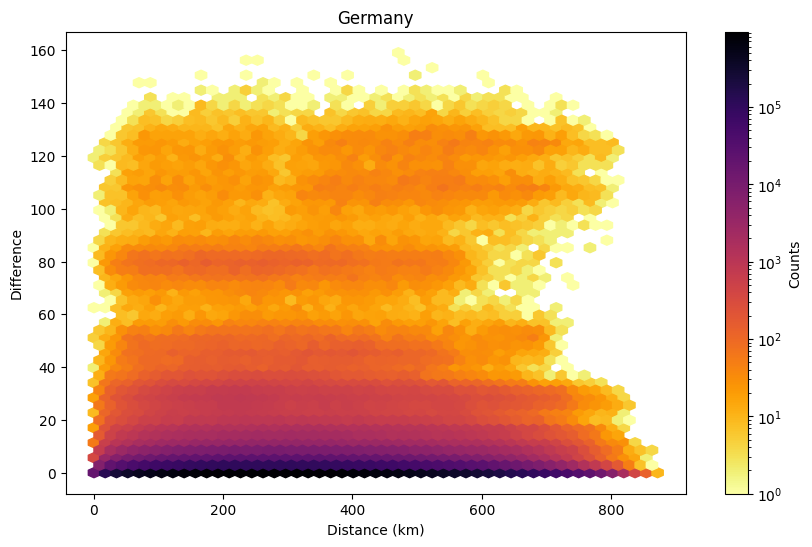

In [4]:
## visualize
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
hb = plt.hexbin(all_dists, all_diffs, gridsize=50,cmap='inferno_r', mincnt=1,bins='log')
cb = plt.colorbar(hb, label='Counts')
# plt.xlim([0,3400])
plt.xlabel('Distance (km)')
plt.ylabel('Difference')
plt.title('Germany')
plt.show()

## Bin the pairwise semivariance

In [5]:
from model_fit import bin_semivar

mask_vc = all_dists <= 1000  # variogram calculting distance, in km
all_dists_filt = all_dists[mask_vc]
all_diffs_filt = all_diffs[mask_vc]

ttprint('start binning')
bins_size = 5 # unit=km
binned_dist, binned_variogram, bin_center, binned_number = bin_semivar(all_dists_filt, all_diffs_filt, bins_size)
ttprint(f'finish binning for bin size {bins_size} km')

[07:54:31] start binning
[07:54:41] finish binning for bin size 5 km


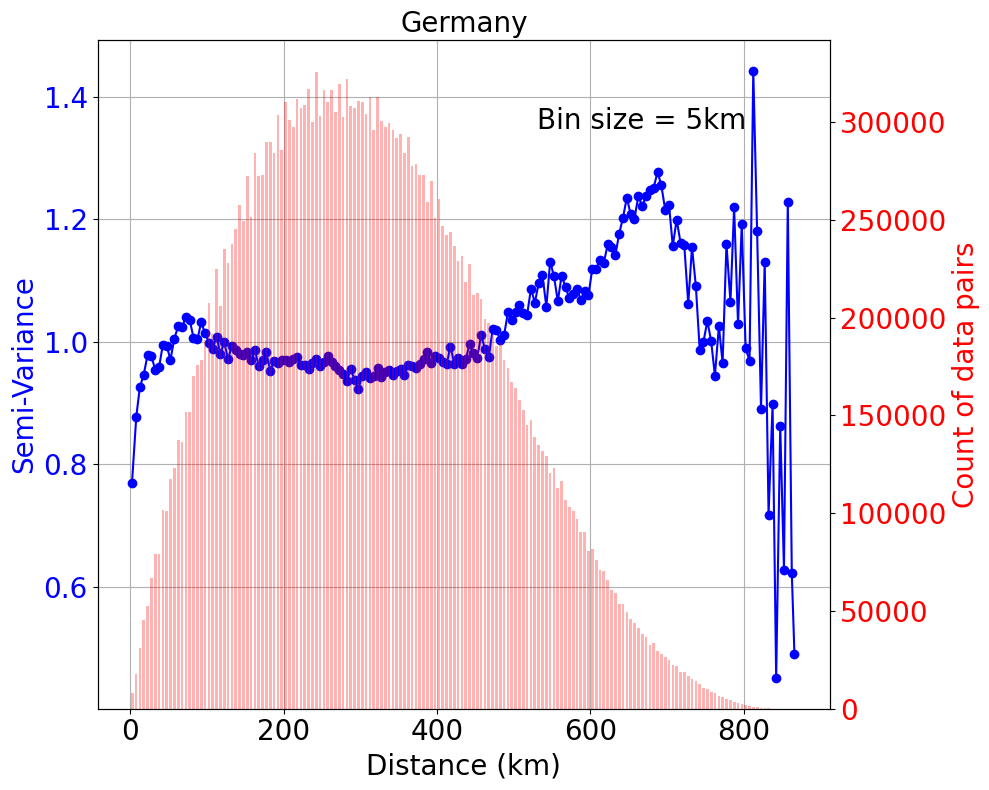

In [6]:
# visualize

fig, ax1 = plt.subplots(figsize=(10, 8))

ax1.plot(binned_dist, binned_variogram, marker='o', linestyle='-', color='b', label='Variogram')
ax1.set_xlabel('Distance (km)', fontsize=20)
ax1.set_ylabel('Semi-Variance', color='b', fontsize=20)
ax1.tick_params(axis='y', labelcolor='b', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.text(0.6, 0.9, f'Bin size = {bins_size}km', 
            ha='left', va='top', transform=ax1.transAxes, fontsize=20)  

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.bar(bin_center, binned_number, width=3.5, alpha=0.3, color='r', label='Histogram')
ax2.set_ylabel('Count of data pairs', color='r', fontsize=20)
ax2.tick_params(axis='y', labelcolor='r', labelsize=20)

plt.title('Germany', fontsize=20)
ax1.grid(True)
# ax1.set_xlim([0,500])
# ax1.set_ylim([0,1])
fig.tight_layout()  

plt.show()

## calculate theoretical variogram

model  nugget,   sill,   range
exponential [ 0.72415892  1.00000001 10.60109839]
spherical [ 0.75150939  0.99646957 26.00897302]
gaussian [ 0.77712257  0.99612556 12.02664429]


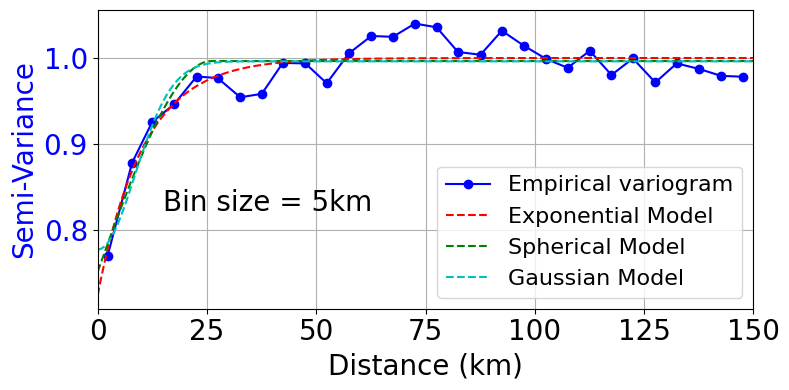

In [7]:
from model_fit import spherical_model, exponential_model, gaussian_model, fit_variogram_model

ts = 150 # truncated distance in km
mask_tc = binned_dist <= ts 
filtered_distances = binned_dist[mask_tc]
filtered_variograms = binned_variogram[mask_tc]

# fit the theoretical variogram
# y = correlation_function(distance, *params_exponential)
params_spherical = fit_variogram_model(spherical_model, filtered_distances, filtered_variograms)
params_exponential = fit_variogram_model(exponential_model, filtered_distances, filtered_variograms)
params_gaussian = fit_variogram_model(gaussian_model, filtered_distances, filtered_variograms)
print('model  nugget,   sill,   range')
print('exponential', params_exponential)
print('spherical', params_spherical)
print('gaussian', params_gaussian)


# illustrate the theoretical one
h_vals = np.linspace(0, ts, 200)
fitted_variogram_spherical = spherical_model(h_vals, *params_spherical)
fitted_variogram_exponential = exponential_model(h_vals, *params_exponential)
fitted_variogram_gaussian = gaussian_model(h_vals, *params_gaussian)

# visualize
fig, ax1 = plt.subplots(figsize=(8,4))

ax1.plot(filtered_distances, filtered_variograms, marker='o', linestyle='-', color='b', label='Empirical variogram')
ax1.set_xlabel('Distance (km)', fontsize=20)
# ax1.set_xlim([0, 200])
ax1.set_ylabel('Semi-Variance', color='b', fontsize=20)
ax1.tick_params(axis='y', labelcolor='b', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.text(0.1, 0.4, f'Bin size = {bins_size}km', 
            ha='left', va='top', transform=ax1.transAxes, fontsize=20)  


ax1.plot(h_vals, fitted_variogram_exponential, linestyle='--', color='r', label='Exponential Model')
ax1.plot(h_vals, fitted_variogram_spherical, linestyle='--', color='g', label='Spherical Model')
ax1.plot(h_vals, fitted_variogram_gaussian, linestyle='--', color='c', label='Gaussian Model')
# plt.title('Germany', fontsize=20)
ax1.grid(True)
ax1.set_xlim([0,ts])
# ax1.set_ylim([-1,2])
fig.tight_layout()  
plt.legend(fontsize=16, loc='lower right')
plt.show()

## get the final variogram and corresponding correlation function

In [8]:
# (sill - gamma_h) / sill
correlation_values = 1-exponential_model(h_vals, *params_exponential)/params_exponential[1]


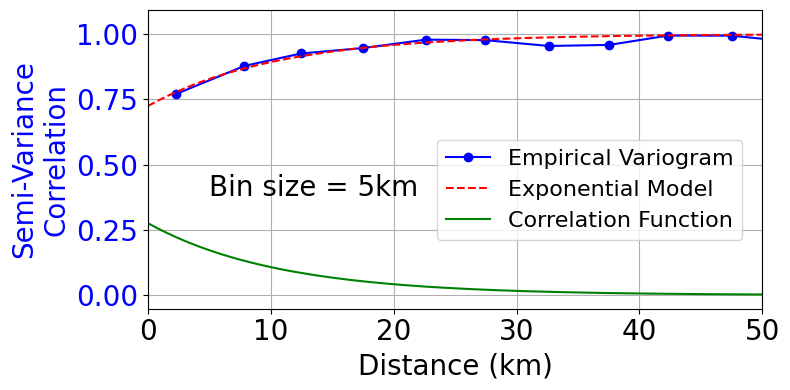

In [10]:
fig, ax1 = plt.subplots(figsize=(8,4))

ax1.plot(filtered_distances, filtered_variograms, marker='o', linestyle='-', color='b', label='Empirical Variogram')
ax1.plot(h_vals, fitted_variogram_exponential, linestyle='--', color='r', label='Exponential Model')
ax1.plot(h_vals, correlation_values, linestyle='-', color='green', label='Correlation Function')
ax1.set_xlabel('Distance (km)', fontsize=20)
ax1.set_ylabel('Semi-Variance\nCorrelation', color='b', fontsize=20)  # Shared y-axis label
ax1.tick_params(axis='y', labelcolor='b', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.text(0.1, 0.45, f'Bin size = {bins_size}km', 
         ha='left', va='top', transform=ax1.transAxes, fontsize=20)  # Adjusted text position, \nSill = {params_exponential[1]:.3f}
ax1.grid(True)
ax1.set_xlim([0, 50])

plt.legend(fontsize=16, loc=(0.47,0.23))
plt.tight_layout()
# plt.savefig(f'./figure/plot_agg_variogram.de.svg', bbox_inches='tight')
plt.show()

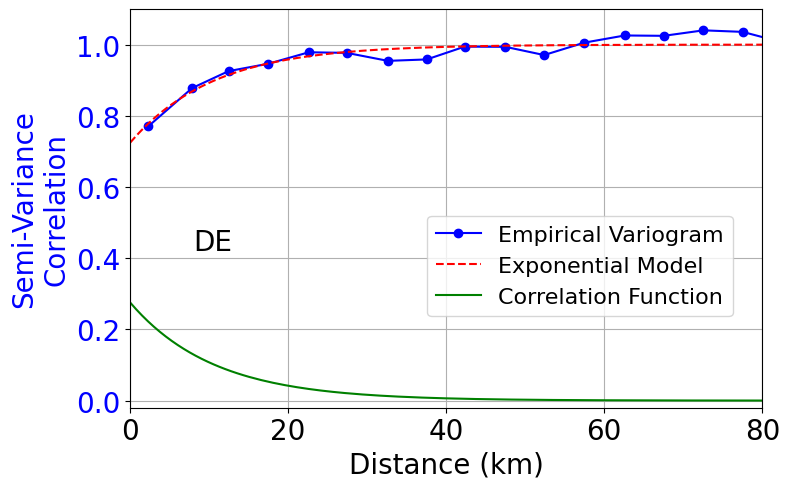

In [15]:
fig, ax1 = plt.subplots(figsize=(8,5))

ax1.plot(filtered_distances, filtered_variograms, marker='o', linestyle='-', color='b', label='Empirical Variogram')
ax1.plot(h_vals, fitted_variogram_exponential, linestyle='--', color='r', label='Exponential Model')
ax1.plot(h_vals, correlation_values, linestyle='-', color='green', label='Correlation Function')
ax1.set_xlabel('Distance (km)', fontsize=20)
ax1.set_ylabel('Semi-Variance\nCorrelation', color='b', fontsize=20)  # Shared y-axis label
ax1.tick_params(axis='y', labelcolor='b', labelsize=20)
ax1.tick_params(axis='x', labelsize=20)
ax1.text(0.1, 0.45, f'DE', 
         ha='left', va='top', transform=ax1.transAxes, fontsize=20)  # Adjusted text position, \nSill = {params_exponential[1]:.3f}
ax1.grid(True)
ax1.set_xlim([0, 80])
ax1.set_ylim([-0.02,1.1])

# ax2 = ax1.twinx()
# ax2.bar(bin_center[mask_tc], binned_number[mask_tc], width=3.5, alpha=0.2, color='r', label='Histogram')
# ax2.set_ylabel('Count of data pairs', color='r', fontsize=20)
# ax2.tick_params(axis='y', labelcolor='r', labelsize=20)

# lines_1, labels_1 = ax1.get_legend_handles_labels()
# lines_2, labels_2 = ax2.get_legend_handles_labels()
# ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc=(0.51,0.23), fontsize=15, facecolor='white', edgecolor='black', framealpha=1)
plt.legend(fontsize=16, loc=(0.47,0.23))
plt.tight_layout()
plt.savefig(f'./figure/plot_agg_variogram.de.svg', bbox_inches='tight')
plt.show()


## log

In [12]:
# from joblib import Parallel, delayed
# from sklearn.model_selection import LeavePOut
# from trees_rf import cast_tree_rf
# import os
# from tqdm import tqdm
# from skmap.misc import TimeTracker, ttprint

# dff = df.sample(10000)

# def process_split(train_idx, test_idx):
#     train = dff.iloc[train_idx]
#     test = dff.iloc[test_idx]

#     mdl.fit(train[cov], train[tgt])
#     qmd = cast_tree_rf(mdl)

#     tree_pred = qmd.predict(test[cov])  
#     tree_pred = np.expm1(tree_pred)

#     pred = np.mean(tree_pred, axis=0)
#     std = np.std(tree_pred, axis=0)

#     test = test.copy()
#     test["pred"] = pred
#     test["std"] = std

#     return test

# lpo = LeavePOut(100)
# num_splits = sum(1 for _ in lpo.split(dff))  # Total iterations
# cl = []
# ttprint('start predicting')

# with tqdm(total=num_splits, desc="Processing splits", unit="split") as pbar:
#     results = Parallel(n_jobs=min(4, os.cpu_count() // 2))(
#         delayed(process_split)(train_idx, test_idx) for train_idx, test_idx in lpo.split(dff)
#     )
#     cl.extend(results)  # Collect results
#     pbar.update(len(results))  # Update progress bar manually
    
# ttprint('finish predicting')